In [1]:
import cobra
import GEMS
import pandas as pd
import numpy as np
import os
import re


import pickle
from etcpy import etc
from etcpy import tempDep
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [2]:
data = GEMS.load_exp_data('../data/ExpGrowth.csv')
path = '../'
params = pd.read_csv(os.path.join(path,'data/model_enzyme_params_new.csv'),index_col=0)
df = etc.calculate_thermal_params(params)

dfae_batch = data[0].set_index('Ts').rename_axis(None)
params

,Topt,Topt_std,Length,Tm,Tm_std,T90,dCpt,dCpt_std,topt_source
P77467,306.15,10,262,328.717325,7.588735,NaN,-4000,1000,predicted
P76077,311.15,10,309,328.717325,7.588735,NaN,-4000,1000,predicted
P76078,310.15,10,95,328.717325,7.588735,NaN,-4000,1000,BullShit
P76079,309.15,10,248,328.717325,7.588735,NaN,-4000,1000,predicted
P76081,310.15,10,356,328.717325,7.588735,NaN,-4000,1000,BullShit
...,...,...,...,...,...,...,...,...,...
P0AG80,313.15,10,438,329.166303,4.070000,330.45,-4000,1000,predicted
P77718,307.15,10,482,319.125751,4.070000,320.15,-4000,1000,predicted
P0A6D5,308.15,10,288,328.762604,7.710000,NaN,-4000,1000,predicted
standard,308.15,10,272,328.762604,7.710000,NaN,-4000,1000,BullShit


In [3]:
mae = cobra.io.load_matlab_model('../models/ecModel.mat')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-29


In [ ]:
mae = cobra.io.load_matlab_model('../models/ecModel.mat')
    
match = re.compile('usage_prot_*', re.IGNORECASE)
for react in mae.reactions:
    if match.match(react.id) and react.lower_bound != -1000:
        ori_lb = react.lower_bound
        react.lower_bound = ori_lb*2

mae.reactions.EX_glc__D_e.lower_bound = -100
mae.reactions.BIOMASS_Ec_iJO1366_core_53p95M.upper_bound = 50

In [4]:
medium = mae.medium
medium

{'EX_ca2_e': 1000.0,
 'EX_cbl1_e': 0.01,
 'EX_cl_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_glc__D_e': 8.5,
 'EX_h2o_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_slnt_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_zn2_e': 1000.0}

In [ ]:
mae.medium['EX_glc__D_e'] = 0

In [ ]:
mae.medium

In [ ]:
mae.medium=medium
mae.medium

In [5]:
params = tempDep.sample_data_uncertainty_with_constraint_increasing_topt(params)
params

,Topt,Topt_std,Length,Tm,Tm_std,T90,dCpt,dCpt_std,topt_source
P77467,310.663465,10,262,328.717325,7.588735,NaN,-3798.321287,1000,predicted
P76077,314.663465,10,309,328.717325,7.588735,NaN,-4498.149195,1000,predicted
P76078,315.720197,10,95,328.717325,7.588735,NaN,-5730.594456,1000,BullShit
P76079,313.063465,10,248,328.717325,7.588735,NaN,-3749.926226,1000,predicted
P76081,315.720197,10,356,328.717325,7.588735,NaN,-2767.799893,1000,BullShit
...,...,...,...,...,...,...,...,...,...
P0AG80,316.353261,10,438,329.166303,4.070000,330.45,-5208.347525,1000,predicted
P77718,309.545150,10,482,319.125751,4.070000,320.15,-5659.649063,1000,predicted
P0A6D5,312.272521,10,288,328.762604,7.710000,NaN,-3950.812793,1000,predicted
standard,314.333781,10,272,328.762604,7.710000,NaN,-3993.889497,1000,BullShit


In [6]:
def aerobic(params):
    # thermalParams: a dictionary with ids like uniprotid_Topt 
    df = etc.calculate_thermal_params(params)
    #mae = pickle.load(open(os.path.join(path,'models/aerobic.pkl'),'rb'))
    mae = cobra.io.load_matlab_model('../models/ecModel.mat')
    
    match = re.compile('usage_prot_*', re.IGNORECASE)
    for react in mae.reactions:
        if match.match(react.id) and react.lower_bound != -1000:
            ori_lb = react.lower_bound
            react.lower_bound = ori_lb*2


    mae.reactions.EX_glc__D_e.lower_bound = -100
    mae.reactions.BIOMASS_Ec_iJO1366_core_53p95M.upper_bound = 50
    #mae.medium['EX_glc__D_e'] = 100
    
    try: 
        rae, gae, oae = etc.simulate_growth(mae,dfae_batch.index+273.15,df=df,sigma=0.5)
    except: 
        rae = np.zeros(dfae_batch.shape[0])
        model = None
    
    rae = [0 if x is None else x for x in rae]
    rae = [0 if x<1e-3 else x for x in rae]
    #print(rae)
    #rexp = GEMS.aerobic_exp_data()['data']
    print(rae)
    print(abs(rae - dfae_batch['r'].values))
    #print('r2_batch:',r2_score(rexp,rae))
    #print('MSE_ae',MSE(rexp,rae))
    return {'growth':np.array(rae), 'glucose':np.array(gae), 'oxygen': np.array(oae)}

In [7]:
rae = aerobic(params)

NGAM is: 3.23
Growth at  20.153299075508016 is:  0.22076534415421292
NGAM is: 3.23
Growth at  23.00151111308503 is:  0.3561638144566152
NGAM is: 3.666948749964016
Growth at  26.331896319367047 is:  0.564716823369424
NGAM is: 4.228097946953468
Growth at  28.251819864188008 is:  0.7031374579251832
NGAM is: 4.675583853845237
Growth at  29.99421176442104 is:  0.8337711228568758
NGAM is: 5.047267123847456
Growth at  31.62212188446705 is:  0.9544908995176793
NGAM is: 5.44939156263788
Growth at  33.61728633658504 is:  1.0922744849146058
NGAM is: 5.950125048399887
Growth at  36.55299482796005 is:  1.2171563652097115
NGAM is: 6.237403245621997
Growth at  38.54155004207803 is:  1.1445291029087974
NGAM is: 6.449817187489966
Growth at  40.20094365636703 is:  1.0704112632283125
NGAM is: 6.681009354243395
Growth at  42.23876395989504 is:  0.9671854768779715
NGAM is: 6.9000236503978725
Growth at  44.453491097574044 is:  0.8459386013585414
NGAM is: 6.974987953458825
Growth at  45.28989924561603 is:  0

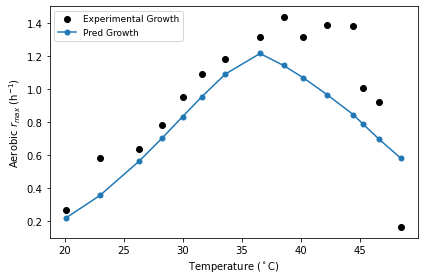

In [8]:
plt.figure()
plt.scatter(dfae_batch.index,dfae_batch['r'].values,label='Experimental Growth',color='k')
plt.plot(dfae_batch.index,rae['growth'],markersize=5,marker='o',label='Pred Growth')
#plt.plot(dfae_batch.index,rae['glucose'],markersize=5,marker='o',label='Glucose')
#plt.plot(dfae_batch.index,rae['oxygen'],markersize=5,marker='o',label='Oxygen')
plt.xlabel('Temperature ($^\circ$C)')
#plt.ylabel('Specific growth rate (h$^{-1}$)')
plt.ylabel('Aerobic $r_{max}$ (h$^{-1}$)')

plt.legend(fontsize=9,loc='upper left')
plt.tight_layout()
plt.savefig('../results/prettyCurve.png')
plt.show()

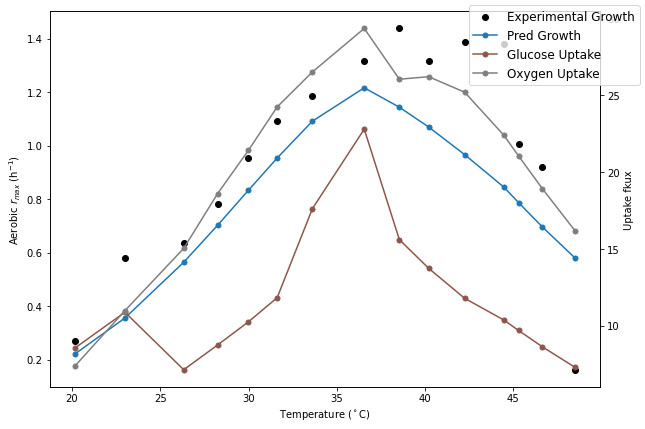

In [9]:

fig, ax1 = plt.subplots(figsize=(9, 6))
ax2 = ax1.twinx()

ax1.scatter(dfae_batch.index,dfae_batch['r'].values,label='Experimental Growth',color='k')
ax1.plot(dfae_batch.index,rae['growth'],markersize=5,marker='o',label='Pred Growth')

ax2.plot(dfae_batch.index,rae['glucose'],markersize=5,marker='o',label='Glucose Uptake', color='tab:brown')
ax2.plot(dfae_batch.index,rae['oxygen'],markersize=5,marker='o',label='Oxygen Uptake', color='tab:gray')

ax1.set_xlabel("Temperature ($^\circ$C)")
ax1.set_ylabel("Aerobic $r_{max}$ (h$^{-1}$)")

ax2.set_ylabel("Uptake fkux")

fig.legend(fontsize=12)
fig.tight_layout()
fig.savefig('../results/prettyCurveMore.png')

In [ ]:
mae.reactions.THZPSN3